In [1]:

# Cell 1: Import Libraries
"""
札幌市 18:00 人口分布熱力圖視覺化
====================================
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.facecolor'] = 'white'

print("✓ 套件載入完成")

✓ 套件載入完成


In [2]:
# Cell 2: Load Processed Data
"""
讀取已處理的札幌密度資料
"""

df = pd.read_parquet('../data/processed/sapporo_density.parquet')

print("資料概覽:")
print(f"- 總資料筆數: {len(df):,}")
print(f"- 欄位: {list(df.columns)}")


資料概覽:
- 總資料筆數: 6,024,808
- 欄位: ['d', 't', 'x', 'y', 'count']


In [3]:
# Cell 3: Filter 18:00 Data
"""
篩選 18 點的資料
"""

df_18 = df[df['t'] == 18].copy()

print(f"✓ 18點資料筆數: {len(df_18):,}")

# 按 x, y 聚合
df_grid = df_18.groupby(['x', 'y'])['count'].mean().reset_index()

print(f"✓ 網格數量: {len(df_grid):,}")
print(f"\n座標範圍:")
print(f"  X: {df_grid['x'].min():.0f} ~ {df_grid['x'].max():.0f}")
print(f"  Y: {df_grid['y'].min():.0f} ~ {df_grid['y'].max():.0f}")

✓ 18點資料筆數: 151,861
✓ 網格數量: 5,458

座標範圍:
  X: 1 ~ 999
  Y: 1 ~ 999


In [4]:
# ============================================================
# Cell 4: Remove Single Top-Right Outlier (Minimal)
"""
只移除右上角那一顆孤立點
"""

print(f"\n原始網格數: {len(df_grid)}")

# 找出最右上角的點
x_max = df_grid['x'].max()
y_max = df_grid['y'].max()

# 定義：同時接近 x_max 且 y_max 的點
df_grid_clean = df_grid[
    ~((df_grid['x'] >= x_max - 1) & (df_grid['y'] >= y_max - 1))
].copy()

removed = len(df_grid) - len(df_grid_clean)

print(f"✓ 移除了 {removed} 個右上角孤立點")
print(f"清理後網格數: {len(df_grid_clean)}")



原始網格數: 5458
✓ 移除了 1 個右上角孤立點
清理後網格數: 5457


In [5]:
# Cell 5: Create Density Matrix
"""
創建密度矩陣
"""

x_min, x_max = int(df_grid_clean['x'].min()), int(df_grid_clean['x'].max())
y_min, y_max = int(df_grid_clean['y'].min()), int(df_grid_clean['y'].max())

print(f"\n清理後數據範圍: X({x_min}-{x_max}), Y({y_min}-{y_max})")

# 創建密度矩陣
density_matrix = np.zeros((y_max - y_min + 1, x_max - x_min + 1))

for _, row in df_grid_clean.iterrows():
    x_idx = int(row['x']) - x_min
    y_idx = int(row['y']) - y_min
    density_matrix[y_idx, x_idx] = row['count']

print(f"✓ 密度矩陣: {density_matrix.shape}")
print(f"  非零格子數: {np.count_nonzero(density_matrix):,}")
print(f"  最大密度: {density_matrix.max():.0f}")

# 輕微平滑
density_smoothed = gaussian_filter(density_matrix, sigma=0.5)

print(f"✓ 已應用平滑 (sigma=0.5)")


清理後數據範圍: X(1-197), Y(1-200)
✓ 密度矩陣: (200, 197)
  非零格子數: 5,457
  最大密度: 71
✓ 已應用平滑 (sigma=0.5)


In [6]:
# Cell 6: Crop to Data Area
"""
裁切到有數據的區域
"""

mask = density_smoothed > 0
rows_with_data = np.any(mask, axis=1)
cols_with_data = np.any(mask, axis=0)

y_data_min = np.where(rows_with_data)[0].min()
y_data_max = np.where(rows_with_data)[0].max()
x_data_min = np.where(cols_with_data)[0].min()
x_data_max = np.where(cols_with_data)[0].max()

# 加 padding
padding = 3
y_data_min = max(0, y_data_min - padding)
y_data_max = min(density_smoothed.shape[0] - 1, y_data_max + padding)
x_data_min = max(0, x_data_min - padding)
x_data_max = min(density_smoothed.shape[1] - 1, x_data_max + padding)

# 裁切
density_cropped = density_smoothed[y_data_min:y_data_max+1, x_data_min:x_data_max+1]

# 上下翻轉
density_flipped = np.flipud(density_cropped)

# 計算座標範圍
x_crop_min = x_min + x_data_min
x_crop_max = x_min + x_data_max
y_crop_min = y_min + y_data_min
y_crop_max = y_min + y_data_max

extent_cropped = [x_crop_min, x_crop_max, y_crop_min, y_crop_max]

print(f"✓ 裁切完成")
print(f"  顯示範圍: X({x_crop_min}-{x_crop_max}), Y({y_crop_min}-{y_crop_max})")
print(f"  圖像大小: {density_cropped.shape}")

✓ 裁切完成
  顯示範圍: X(1-197), Y(1-200)
  圖像大小: (200, 197)


In [7]:
# Cell 7: Create Colormap
"""
創建配色方案
"""

colors = ['#00000000', '#fff5f0', '#fee0d2', '#fcbba1', '#fc9272', 
          '#fb6a4a', '#ef3b2c', '#cb181d', '#a50f15', '#67000d']
cmap = LinearSegmentedColormap.from_list('heat', colors, N=256)

print("✓ 配色方案完成")

✓ 配色方案完成


✓ 熱力圖繪製完成


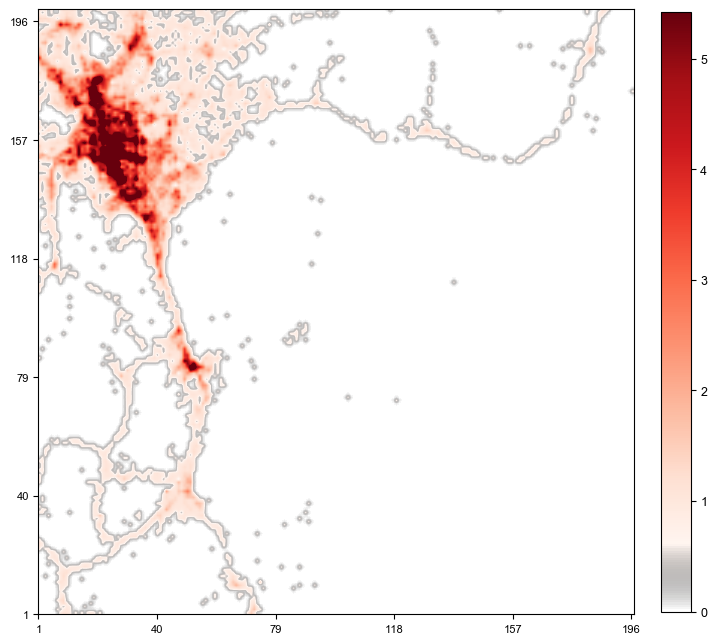

In [11]:
# Cell 8: Create Visualization
"""
繪製熱力圖
"""

fig, ax = plt.subplots(figsize=(7, 7))

im = ax.imshow(density_flipped, 
               origin='upper',
               extent=extent_cropped,
               cmap=cmap,
               aspect='equal',
               interpolation='bilinear',
               vmin=0,
               vmax=np.percentile(density_smoothed[density_smoothed > 0], 98))

# 設定刻度
x_step = max(10, (x_crop_max - x_crop_min) // 5)
y_step = max(10, (y_crop_max - y_crop_min) // 5)

ax.set_xticks(np.arange(x_crop_min, x_crop_max + 1, x_step))
ax.set_yticks(np.arange(y_crop_min, y_crop_max + 1, y_step))
ax.tick_params(axis='both', labelsize=8)

# 顏色條
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=9)

# 無標籤標題
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid(False)

# 確保範圍緊湊
ax.set_xlim(x_crop_min, x_crop_max)
ax.set_ylim(y_crop_min, y_crop_max)
ax.margins(0)

plt.tight_layout(pad=0.1)

print("✓ 熱力圖繪製完成")

In [13]:
# Cell 9: Save and Display
"""
保存並顯示圖片
"""

import os
output_dir = '../output'
os.makedirs(output_dir, exist_ok=True)

output_path = f'{output_dir}/sapporo_18pm_heatmap.png'
fig.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ 圖片已保存至: {output_path}")

plt.show()

print("\n" + "="*60)
print("完成!")
print("="*60)
print(f"處理的資料點數量: {len(df_grid_clean):,}")
print(f"顯示範圍: X({x_crop_min}-{x_crop_max}), Y({y_crop_min}-{y_crop_max})")
print("="*60)

✓ 圖片已保存至: ../output/sapporo_18pm_heatmap.png

完成!
處理的資料點數量: 5,457
顯示範圍: X(1-197), Y(1-200)
